# Question 1: How can a Decision Tree be used to classify celestial objects (Stars, Galaxies, and Quasars)

## Introduction

### Overview

In this notebook I will explain how a decision tree can be used to classify different objects within a dataset. The dataset being used is the SDSS DR14 obtained from Kaggle: https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey/data.

In this dataset, there are 18 columns that are used to describe the Stars, Galaxies, and Quasars observed by the SDSS telescope. However we don't necessarily need all 18 of these parameters. Columns: "objid", "run", "rerun", "camcol", "field", "specobjid", "plate", "mjd", and "fiberid", are all values related to the telescope and thus are not relevant. Columns: "ra", "dec", "u", "g", "r", "i", "z", and "redshift" are all values related to the objects themselves. The "class" column contains which group the objects fall into, this will be used to in testing to see how accuracte the model is.

I chose to use only the five filter bands: "u", "g", "r", "i", and "z". This is because these are the only values that are actually observed by the telescope, and thus should be all that is needed to determine the classification of the objects. "ra" and "dec" are coordinates of the objects in the sky, which is irrelevant to determining what the object is. "redshift" can be included, and I do show how it affects the model at the end of the notebook.

### How does a Decision Tree work?

Decision trees are flow charts that are often used for classification or regression tasks. It works by splitting data into subsets based on the answer to a question. For example in this dataset, you could split the data based on the question "is the brightness above a certain value?" This would then split the data into two subsets, one with brightnesses greater than the chosen value, and one with brightnesses less than the chosen value.

This is repeated with different questions and eventually forms a tree structure with each splitting point forming a "node". It would end up looking something like this:

            Is brightness > 50?
                /         \
              Yes         No
             /             \
        Is size > 30?   Is size > 10?
          /     \         /     \
       Galaxy  Star    Quasar   Star

This method is useful for classification problems as it can be very quick to find an answer, depending on the dataset and the depth of your tree.

## Imports

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Initialising the dataset

In order to use the data, it needs to be initialised. First we load the data from a csv file and store it as a pandas dataframe.

In [4]:
# change the path to where the csv file is stored on your pc
path = '/Users/ryanu/Documents/Uni/ACT/SDSS-DR14-Classification/SDSS Data.csv'
data = pd.read_csv(path)
data

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


Once the data has been loaded, we select only the columns we are going to be using.

In [124]:
parameters = data[["u", "g", "r", "i", "z"]]
classification_examples = data["class"]
parameters

,u,g,r,i,z
0,19.47406,17.04240,15.94699,15.50342,15.22531
1,18.66280,17.21449,16.67637,16.48922,16.39150
2,19.38298,18.19169,17.47428,17.08732,16.80125
3,17.76536,16.60272,16.16116,15.98233,15.90438
4,17.55025,16.26342,16.43869,16.55492,16.61326
...,...,...,...,...,...
9995,18.81777,17.47053,16.91508,16.68305,16.50570
9996,18.27255,17.43849,17.07692,16.71661,16.69897
9997,18.75818,17.77784,17.51872,17.43302,17.42048
9998,18.88287,17.91068,17.53152,17.36284,17.13988


## Testing and Training the model

The data needs to be split into two parts, training and testing. The training set will be used to train the model on how to classify the objects. The testing set is then used to determine how good the model is at classifying objects.

The scikit-learn function, train_test_split, is used to separate the data into a 80/20 (train/test) ratio. It takes the dataset that you want to train the model with as well as the set of labels.

80/20 is a common ratio choice as it ensures there is enough data to actually teach the model the underlying patterns and relationships present while still having a relatively large testing set. This ratio can be changed by increasing or decreasing the test_size parameter.

Setting the random states ensures that each time the cell is run, the random processes within the algorithm (such as splitting the data) will produce the same results. 42 is an arbitary choice but is a convention in data science, in practice any integer can be used. It is a reference to Douglous Adams' book "The Hitchhiker's Guide to the Galaxy".

The function will return four arrays:
- training_param: The feature matrix for the training set, contains the input features used to train the model
- testing param = The feature matrix for the test set, contains the input features used to evaluate how good the model is
- train_classification = The target vector for the training set, contains the true labels that the model will train with
- testing_classification = The target vecotr for the test set, contains the true labels that the model will be tested against

In [66]:
training_param, testing_param, train_classification, testing_classification = train_test_split(parameters, classification_examples, test_size=0.2, random_state=42)

clf is the standard abbreviation for "classifier". It stores the model that we are working with.

The DecisionTreeClassifier class is from scikit-learn and creates the decision tree classifier. By default, a depth for the tree is not set. This means the model will grow until all the leaves are pure or until all leaves contain less than the minimum number of samples required to split. I explain later on in the notebook reasons for and against setting a depth and what a good depth would be for this task. Again the random seed is set to 42.

Running .fit on clf is what actualyl trains the model. It uses the training set as input features and the training classification set as the labels. This is where the data is split into subsets and the tree structure is built.

In [68]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(training_param, train_classification); # The semicolon suppresses the output as it is not useful

Now we run .predict on the model. This is where the model is tested on new data (the testing set we stored earlier). This will generate a class label for each of the objects in the testing set and store them all to an array.

In [49]:
classification_predict = clf.predict(testing_param)
print(classification_predict)

['GALAXY' 'QSO' 'STAR' ... 'STAR' 'STAR' 'GALAXY']


Now we can determine how accurate the model is by comparing the predicted classification with the true classification.

classification_report is an sklearn function that generates a detailed report of the classification model's performance, broken down based on each class.
  - Precision: The proportion of true positive predictions out of all positive predictions made
  - Recall (Sensitivity): The proportion of true positive predictions out of all actual positives
  - F1-Score: The harmonic mean of precision and recall
  - Support: The number of actual occurences of each class in the testing set
  - Accuracy: The proportion of correctly classified labels out of the total number of labels
  - Macro avg: The average of the precision, recall, and F1-score for each class, calculated independently for each class and then averaged
  - Weighted avg: The average of the precision, recall, and F1-score for each class, weighted by the number of instances in each class.

In [65]:
# Print the classification report to 4 decimal places
print("Classification Report:\n\n", classification_report(testing_classification, classification_predict, digits=4))

Classification Report:

               precision    recall  f1-score   support

      GALAXY     0.9129    0.9157    0.9143       996
         QSO     0.8710    0.8526    0.8617       190
        STAR     0.8933    0.8943    0.8938       814

    accuracy                         0.9010      2000
   macro avg     0.8924    0.8875    0.8899      2000
weighted avg     0.9009    0.9010    0.9010      2000



## Plotting the model

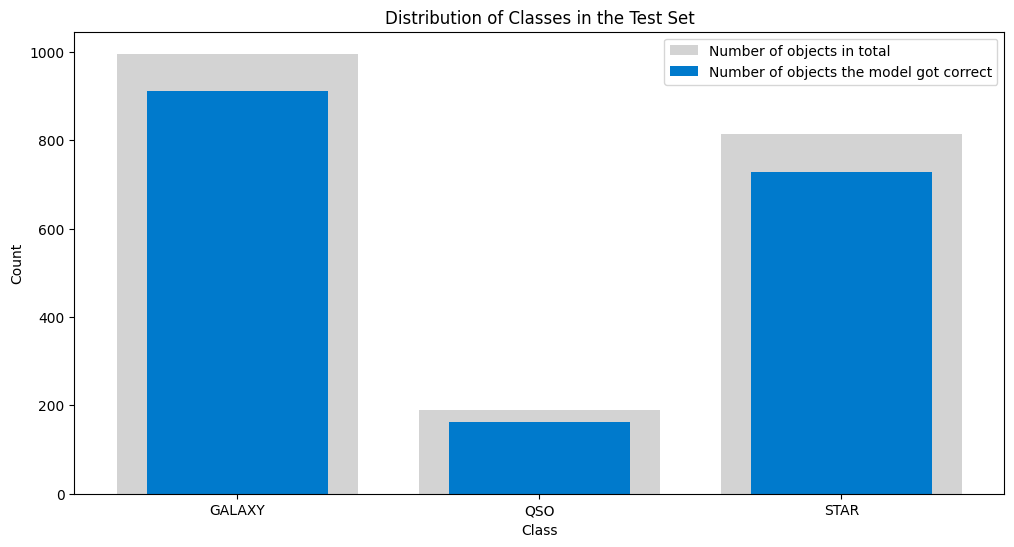

In [144]:
# Calculates the true number of objects in each class and sorts them by class
true_counts = testing_classification.value_counts().sort_index()

# Calculates the number of objects the model correctly identified for each class and sorts them by class
correct_counts = testing_classification[testing_classification == classification_predict].value_counts().sort_index()

# Combines true_counts and correct_counts into a single DataFrame for easier plotting
plot_data = pd.DataFrame({'Actual': true_counts, 'Correctly Detected': correct_counts})

# Sets the x positions for the bars, so that they are evenly spaced along the x axis
x_positions = np.arange(len(plot_data))

# Create the bar plot
plt.figure(figsize=(12, 6)) # Set the figure size to be 12 inches by 6 inches (width by height), can be adjusted as needed
plt.bar(x_positions, plot_data['Actual'], width=0.8, color='#d3d3d3', label='Number of objects in total') # Plot the actual counts as light gray bars
plt.bar(x_positions, plot_data['Correctly Detected'], width=0.6, color='#007acc', label='Number of objects the model got correct') # Plot the correctly detected counts as blue bars

# Add a title and labels
plt.title('Distribution of Classes in the Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Sets x-axis tick labels to class names instead of numbers
plt.xticks(x_positions, plot_data.index)

# Add a legend and show the plot
plt.legend(loc='upper right')
plt.show()